In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely.ops as so
import pandas as pd
import numpy as np

import importlib
import utils.serviceArea
importlib.reload(utils.serviceArea)
import utils.serviceArea as serviceArea

# Load subzone shape file

In [3]:
subzone_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019SubzoneBoundaryNoSeaGEOJSON.shp")
subzone_shp.head()

Name                                         Descriptio SUBZONE_NO  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...         12   
1  kml_2  <center><table><tr><th colspan='2' align='cent...          2   
2  kml_3  <center><table><tr><th colspan='2' align='cent...          3   
3  kml_4  <center><table><tr><th colspan='2' align='cent...          4   
4  kml_5  <center><table><tr><th colspan='2' align='cent...          5   

       SUBZONE_N SUBZONE_C                                           geometry  
0     DEPOT ROAD    BMSZ12  POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2...  
1    BUKIT MERAH    BMSZ02  POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28...  
2      CHINATOWN    OTSZ03  POLYGON Z ((103.84375 1.28508 0, 103.844 1.284...  
3        PHILLIP    DTSZ04  POLYGON Z ((103.84962 1.28412 0, 103.84955 1.2...  
4  RAFFLES PLACE    DTSZ05  POLYGON Z ((103.85253 1.28617 0, 103.85253 1.2...

# load planning area shp file

In [4]:
planningArea_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019_PlanningArea_Fixed.shp")
planningArea_shp.head()

Name                                         Descriptio  \
0   kml_1  <center><table><tr><th colspan='2' align='cent...   
1   kml_4  <center><table><tr><th colspan='2' align='cent...   
2  kml_12  <center><table><tr><th colspan='2' align='cent...   
3  kml_24  <center><table><tr><th colspan='2' align='cent...   
4  kml_27  <center><table><tr><th colspan='2' align='cent...   

              PLN_AREA_N PLN_AREA_C CA_IND                 _errors  \
0                  BEDOK         BD      N  Ring self-intersection   
1            BUKIT MERAH         BM      N  Ring self-intersection   
2            JURONG EAST         JE      N  Ring self-intersection   
3  NORTH-EASTERN ISLANDS         NE   None  Ring self-intersection   
4       SOUTHERN ISLANDS         SI      N  Ring self-intersection   

              layer                                               path  \
0  Fixed geometries  MultiPolygonZ?crs=EPSG:4326&field=Name:string(...   
1  Fixed geometries  MultiPolygonZ?crs=EPSG:4326&field=Name:string(...   
2  Fixed geometries  MultiPolygonZ?crs=EPSG:4326&field=Name:string(...   
3  Fixed geometries  MultiPolygonZ?crs=EPSG:4326&field=Name:string(...   
4  Fixed geometries  MultiPolygonZ?crs=EPSG:4326&field=Name:string(...   

                                            geometry  
0  POLYGON Z ((103.93208 1.30555 0, 103.93209 1.3...  
1  POLYGON Z ((103.82361 1.26018 0, 103.82361 1.2...  
2  MULTIPOLYGON Z (((103.70983 1.30775 0, 103.709...  
3  MULTIPOLYGON Z (((104.05483 1.43133 0, 104.054...  
4  MULTIPOLYGON Z (((103.83332 1.21666 0, 103.833...

# Obtain building footprints

In [14]:
# configure the place, network type, trip times, and travel speed
place = {"city": "Singapore", "country": "Singapore"}
# get all building footprints in some neighborhood
# `True` means retrieve any object with this tag, regardless of value
tags = {"building": True}
buildingFootprint = ox.features_from_place(place, tags)
# filter only polygon geometry, exclude point
buildingFootprint = buildingFootprint[buildingFootprint['geometry'].apply(lambda x: isinstance(x,Polygon))]
buildingFootprint.shape

(123542, 505)

<Axes: >

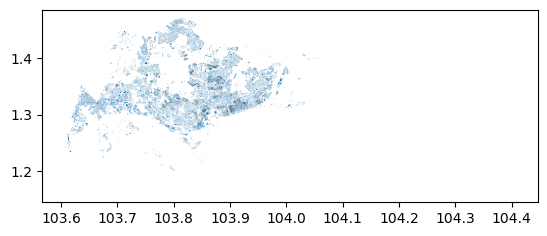

In [16]:
buildingFootprint.plot()

In [24]:
import re
buildingFootprint[[i for i in buildingFootprint.columns.to_list() if bool(re.search(".*name.*",i))]]
buildingFootprint.columns.to_list()

['geometry',
 'addr:city',
 'addr:country',
 'addr:housename',
 'addr:housenumber',
 'addr:postcode',
 'addr:street',
 'bench',
 'bin',
 'building',
 'building:levels',
 'building:part',
 'bus',
 'height',
 'highway',
 'image',
 'lit',
 'location',
 'mapillary',
 'name',
 'name:en',
 'name:zh',
 'operator',
 'public_transport',
 'ref',
 'route_ref',
 'shelter',
 'shop',
 'tactile_paving',
 'wheelchair',
 'wikidata',
 'int_name',
 'source',
 'barrier',
 'amenity',
 'religion',
 'military',
 'tourism',
 'note',
 'landuse',
 'brand',
 'brand:wikidata',
 'brand:wikipedia',
 'branch',
 'phone',
 'website',
 'construction',
 'building:use',
 'leisure',
 'alt_name',
 'fixme',
 'addr:place',
 'railway',
 'alt_name:en',
 'network',
 'was:monorail',
 'was:public_transport',
 'was:railway',
 'name:ms',
 'short_name',
 'bunker_type',
 'toilets:wheelchair',
 'opening_hours',
 'sport',
 'shelter_type',
 'construction_end_expected',
 'construction_start_expected',
 'layer',
 'name:ta',
 'network:shor

### Derive maximum potential exposure
Maximum potential exposure is defined as area of planningArea minus area of buildingFootprint

planning Area: 0    21.733905
dtype: float64, building area: 5.13496470017874


np.float64(16.598940438337088)

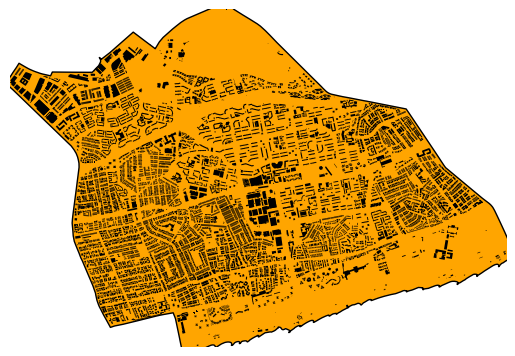

In [47]:
def calculate_gdf_area(gdf):
    """ 
    Args:
        gdf (gdf): polygon collection in a gdf that represents the union of the service area
    Returns:
        float: Area of service area in km2
    """
    gdf = gdf.to_crs({'proj':'cea'})
    # area = gdf.geometry[0].area/10**6 # [0] for index 0, to avoid error, make sure the gdf has 1 item and reset_index() is applied
    # print(f'Area: {area} km2')
    return gdf.geometry.area/10**6

def get_maximum_potential_exposure(buildingFootprint,planningArea, plot = True, ax = None):
    """ Maximum potential exposure is defined as area of planningArea minus area of buildingFootprint
    Args:
        buildingFootprint (gdf): gdf of building footprints in polygon
        planningArea (gdf): gdf of planningArea, which acts as a clipping mask
        plot (bool): if plot is True, plot polygon footprint
        ax (Axes): if None, plot on a new figure
    Returns:
        float: area of maximum potential exposure in km2
    """
    buildingFootprint_clipped = gpd.clip(buildingFootprint,planningArea)

    if plot:
        ax = planningArea.plot(ax=ax,ec="black",fc="orange")
        fig, ax = ox.plot_footprints(buildingFootprint_clipped,ax=ax,color="black",show=False,close=False)
        
    # buildingFootprint_clipped.plot()
    buildingFootprint_area = calculate_gdf_area(buildingFootprint_clipped)
    buildingFootprint_area = buildingFootprint_area.sum() # sum up all polygon's area
    # get planning area area
    planningArea_area = calculate_gdf_area(planningArea)
    print(f'planning Area: {planningArea_area}, building area: {buildingFootprint_area}')
    mpe = planningArea_area - buildingFootprint_area
    return mpe.values[0]

get_maximum_potential_exposure(buildingFootprint,planningArea_shp.loc[[0],['geometry']])

### Calculate MPE per planning area

planning Area: 0    21.733905
dtype: float64, building area: 5.13496470017874
planning Area: 1    14.461198
dtype: float64, building area: 2.2456299753913056
planning Area: 2    17.860003
dtype: float64, building area: 2.8762201751380276
planning Area: 3    67.249672
dtype: float64, building area: 0.15701221776596191
planning Area: 4    7.126186
dtype: float64, building area: 0.6211815180829224
planning Area: 5    8.282764
dtype: float64, building area: 2.124803842384857
planning Area: 6    11.140156
dtype: float64, building area: 1.6383275891768858
planning Area: 7    9.01993
dtype: float64, building area: 1.1094589808194535
planning Area: 8    17.514937
dtype: float64, building area: 3.5732496149210933
planning Area: 9    41.470754
dtype: float64, building area: 2.3827099344595766
planning Area: 10    6.11728
dtype: float64, building area: 1.3392481329739012
planning Area: 11    9.521313
dtype: float64, building area: 2.013955692031208
planning Area: 12    13.933031
dtype: float64, b

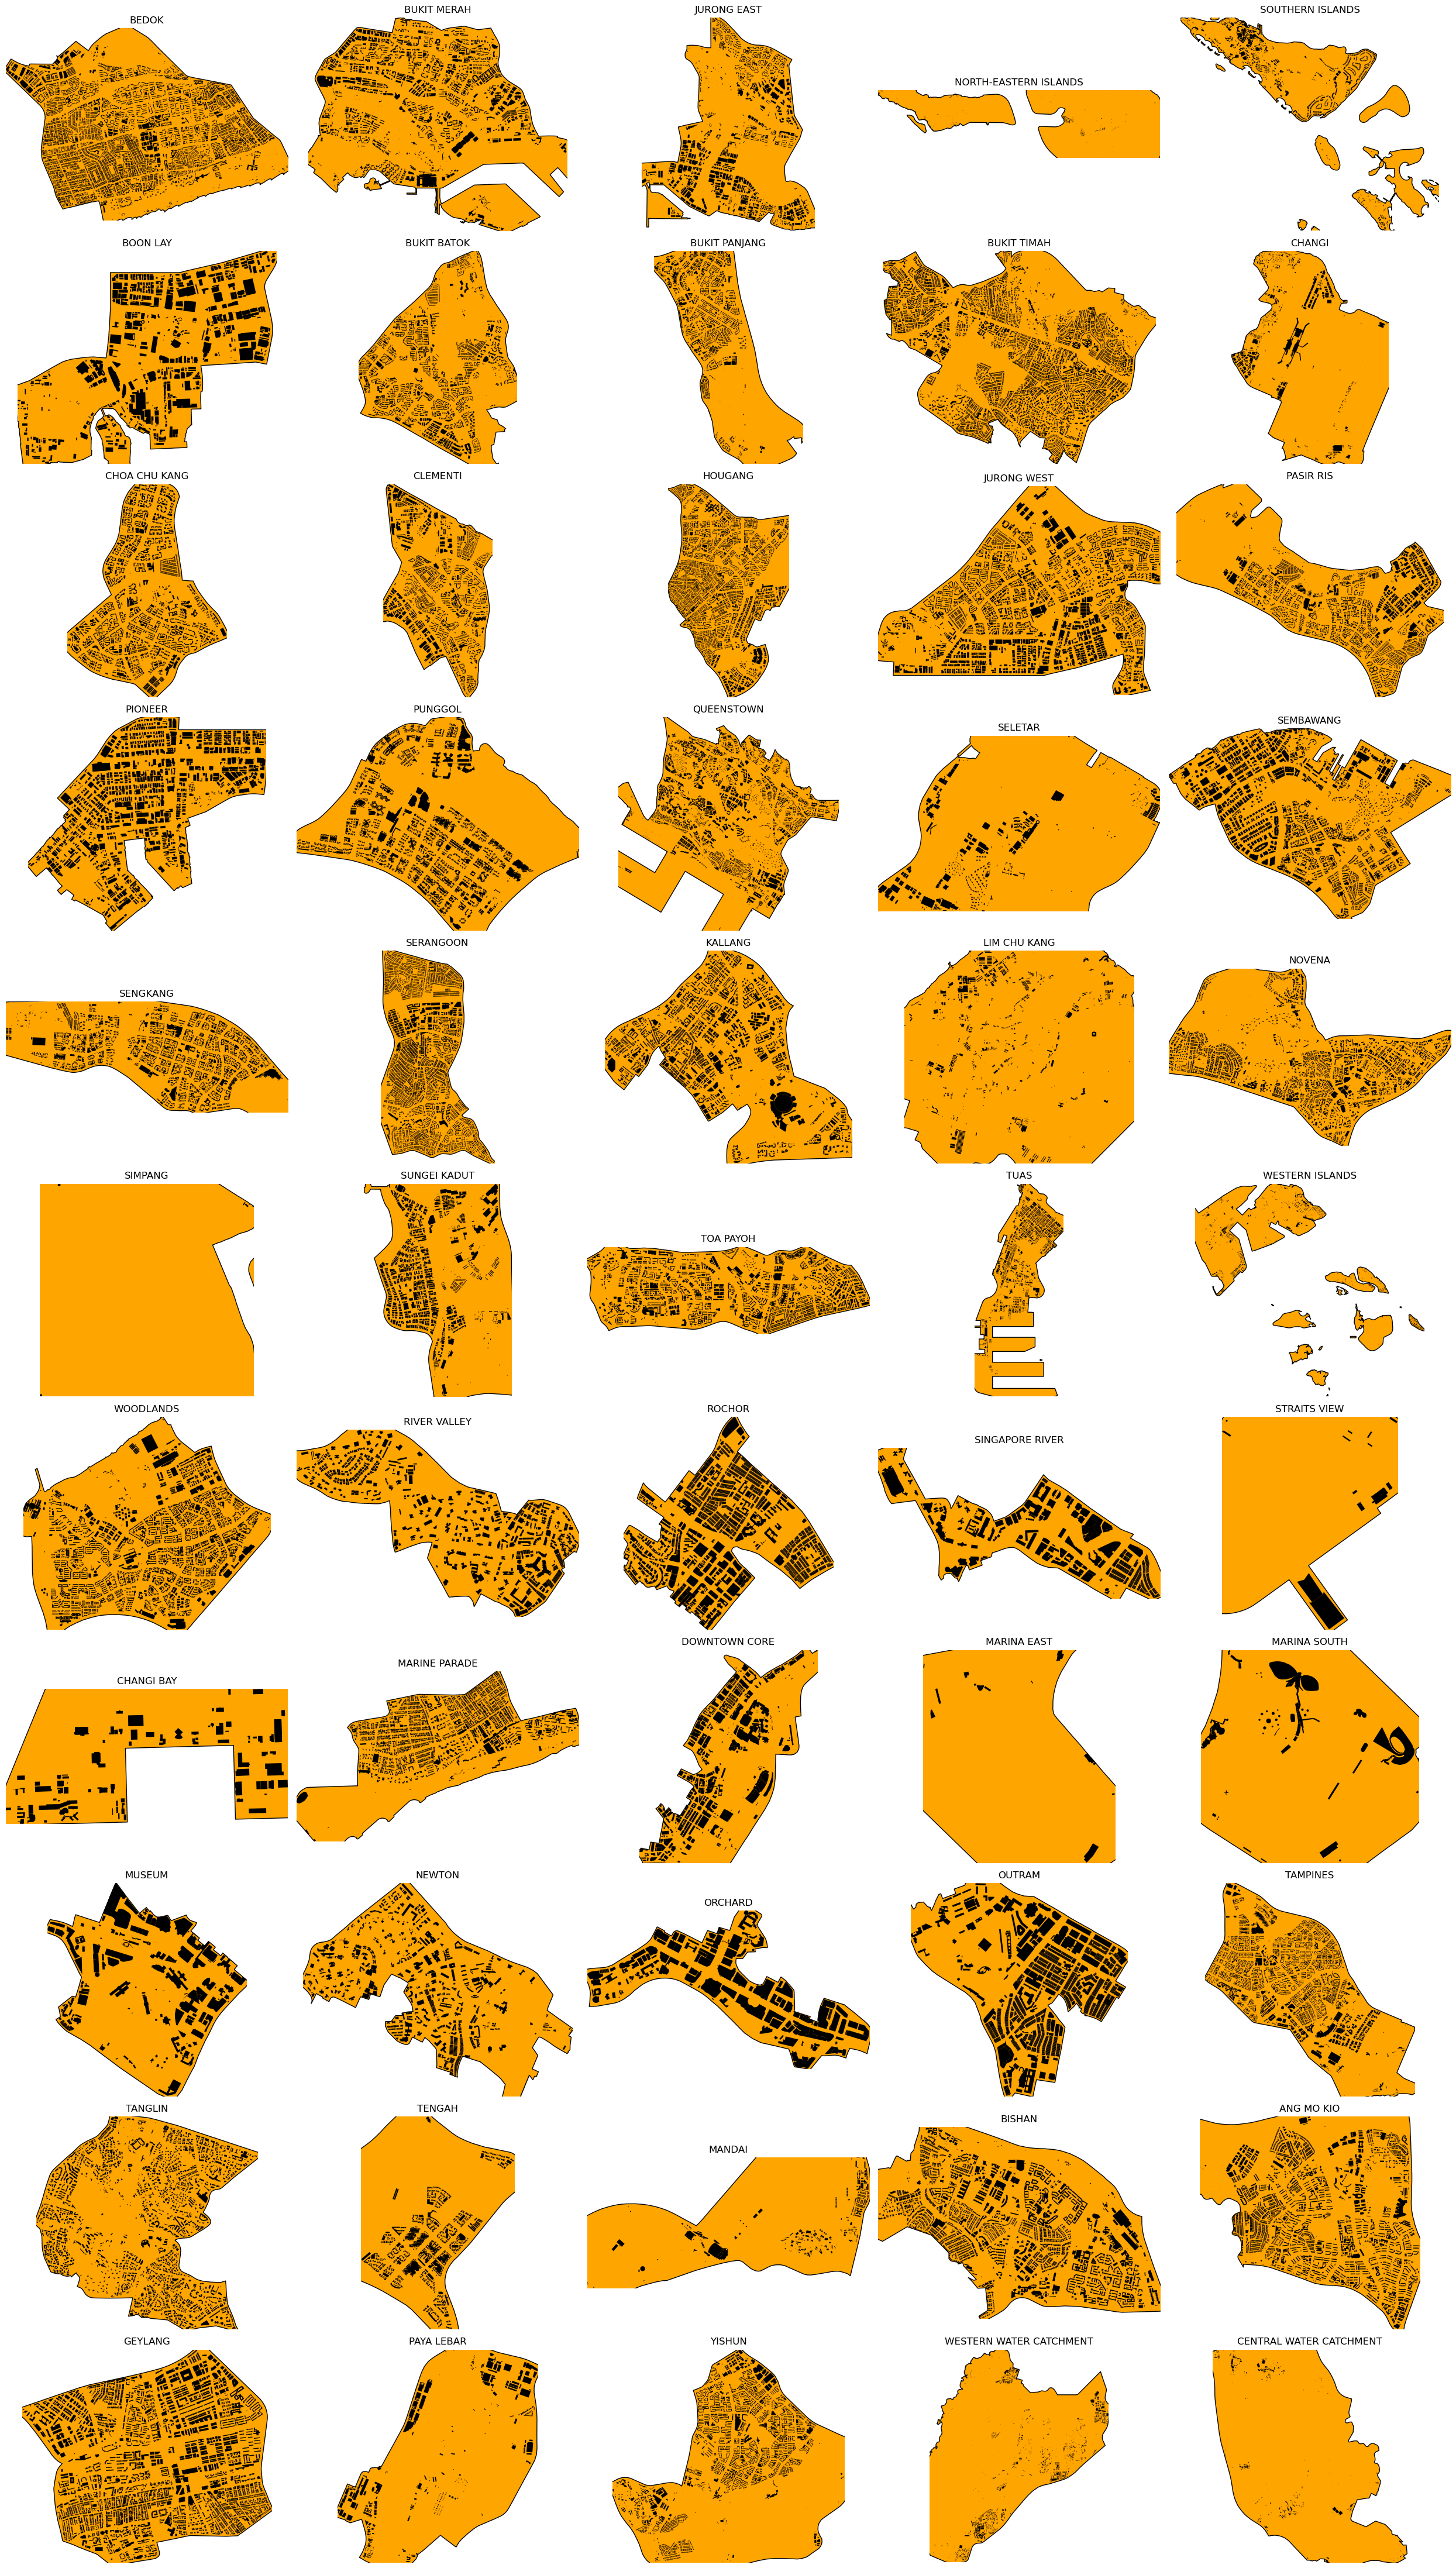

In [48]:
# # save walking network
save_dir = os.path.join(os.getcwd(),"data")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# store MPE values
MPE_planningArea = []

# Exclude the islands
N_graphs = planningArea_shp.shape[0]
ncols = 5
nrows = N_graphs//ncols
fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*5,nrows*4))
for i,ax in enumerate(axes.flatten()):
    # get name of planning area
    place_N = planningArea_shp.loc[i,'PLN_AREA_N']
    place_C = planningArea_shp['PLN_AREA_C'][i]
    # calculate area of planning area
    planningArea_area = calculate_gdf_area(planningArea_shp.loc[[i],['geometry']])
    planningArea_area = planningArea_area.values[0]
    # calculate MPE
    mpe_area = get_maximum_potential_exposure(buildingFootprint,planningArea_shp.loc[[i],['geometry']],
                                              ax=ax)
    # append data to list
    MPE_planningArea.append({'PLN_AREA_N':place_N,
                                        'PLN_AREA_C':place_C,
                                        'MPE_km2': mpe_area,
                                        'planningArea_km2': planningArea_area,
                                        'MPE_ratio':mpe_area/planningArea_area})
    # set title for sub figures
    ax.set_title(place_N)

# save figure
plt.tight_layout()
fp_save = os.path.join(save_dir,"planningArea_maximumPotentialExposure.png")
plt.savefig(fp_save, bbox_inches = 'tight')
plt.show()

# save to csv
MPE_df = pd.DataFrame(MPE_planningArea)
MPE_df.to_csv(os.path.join(save_dir,"planningArea_maximumPotentialExposure.csv"),index=False)

# Calculate MPE per subzone

In [50]:
subzone_shp.head()

Name                                         Descriptio SUBZONE_NO  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...         12   
1  kml_2  <center><table><tr><th colspan='2' align='cent...          2   
2  kml_3  <center><table><tr><th colspan='2' align='cent...          3   
3  kml_4  <center><table><tr><th colspan='2' align='cent...          4   
4  kml_5  <center><table><tr><th colspan='2' align='cent...          5   

       SUBZONE_N SUBZONE_C                                           geometry  
0     DEPOT ROAD    BMSZ12  POLYGON Z ((103.81454 1.28239 0, 103.81774 1.2...  
1    BUKIT MERAH    BMSZ02  POLYGON Z ((103.82209 1.28049 0, 103.8221 1.28...  
2      CHINATOWN    OTSZ03  POLYGON Z ((103.84375 1.28508 0, 103.844 1.284...  
3        PHILLIP    DTSZ04  POLYGON Z ((103.84962 1.28412 0, 103.84955 1.2...  
4  RAFFLES PLACE    DTSZ05  POLYGON Z ((103.85253 1.28617 0, 103.85253 1.2...

In [51]:
# # save walking network
save_dir = os.path.join(os.getcwd(),"data")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# store MPE values
MPE_subzone = []

for i in range(subzone_shp.shape[0]):
    # get name of planning area
    place_N = subzone_shp.loc[i,'SUBZONE_N']
    place_C = subzone_shp['SUBZONE_C'][i]
    # calculate area of planning area
    subzone_area = calculate_gdf_area(subzone_shp.loc[[i],['geometry']])
    subzone_area = subzone_area.values[0]
    # calculate MPE
    mpe_area = get_maximum_potential_exposure(buildingFootprint,subzone_shp.loc[[i],['geometry']],
                                              plot=False)
    # append data to list
    MPE_subzone.append({'SUBZONE_N':place_N,
                                        'SUBZONE_C':place_C,
                                        'MPE_km2': mpe_area,
                                        'subzone_km2': subzone_area,
                                        'MPE_ratio':mpe_area/subzone_area})


# save to csv
MPE_df = pd.DataFrame(MPE_subzone)
MPE_df.to_csv(os.path.join(save_dir,"subzone_maximumPotentialExposure.csv"),index=False)

planning Area: 0    0.442297
dtype: float64, building area: 0.18551551240060188
planning Area: 1    0.411723
dtype: float64, building area: 0.10268540722444869
planning Area: 2    0.587223
dtype: float64, building area: 0.29601122487390796
planning Area: 3    0.039438
dtype: float64, building area: 0.016660749447912338
planning Area: 4    0.188767
dtype: float64, building area: 0.10373213966500569
planning Area: 5    0.133007
dtype: float64, building area: 0.07883794318154586
planning Area: 6    0.448128
dtype: float64, building area: 0.13022078246562263
planning Area: 7    0.5212
dtype: float64, building area: 0.11556300802332936
planning Area: 8    0.350788
dtype: float64, building area: 0.09371961363546227
planning Area: 9    0.261844
dtype: float64, building area: 0.026657138641798642
planning Area: 10    1.630379
dtype: float64, building area: 0.07978097211207838
planning Area: 11    0.614923
dtype: float64, building area: 0.04770308856844105
planning Area: 12    1.844041
dtype: f